## Vanilla REINFORCE pseudocode:


<img src="files/sc1.png" alt="Drawing" style="width: 500px; float:left;"/>

Collected from [Udacity Deep Reinforcement Learning Nanodegree.](https://classroom.udacity.com/nanodegrees/nd893) 
<br>

Here I'll solve the Cartpole environment using REINFORCE. I'll follow (not completely) the implementation details given [here](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb). 

### 1. Imports

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define Policy Network

Very simple fully connected neural network.

In [2]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.LeakyReLU(),
            nn.Linear(64, action_size)
        )
        
    def forward(self, x):
        return F.softmax(self.fc(x), dim=1)

### 3. Define Agent 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99            # discount factor
LR = 5e-3               # learning rate

class Agent: 
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.policy = Policy(state_size, action_size).to(device) 
        self.optimizer = optim.Adam(self.policy.parameters(), lr=LR)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        actions_probs = self.policy(state).cpu()
        m = Categorical(actions_probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
        

    def learn(self, rewards, log_probs):
        # rewards (list): the rewards the agent received in the episode
        # log_probs (list): log probabilities of the actions (log pi_theta(a_t|s_t))
        
        R = self._calc_rewards(rewards)
        policy_loss = []
        for R_t, log_t in zip(R, log_probs): 
            policy_loss.append(-R_t * log_t)
        policy_loss = torch.cat(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
            
        
    def _calc_rewards(self, rewards):
        ret = []
        c_reward = 0.0
        for reward in reversed(rewards):
            c_reward *= GAMMA
            c_reward += reward
            ret.append(c_reward)
        return list(reversed(ret))

### 4. REINFORCE

In [4]:
env = gym.make('CartPole-v0')

state_size = 4
action_size = 2

print('state size:', state_size)
print('action size:', action_size)

agent = Agent(state_size, action_size)

def REINFORCE(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = agent.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                agent.learn(rewards, saved_log_probs)
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = REINFORCE()
    

state size: 4
action size: 2
Episode 100	Average Score: 55.12
Episode 200	Average Score: 166.77
Episode 300	Average Score: 171.17
Environment solved in 248 episodes!	Average Score: 195.02


### 5. Rewards plot

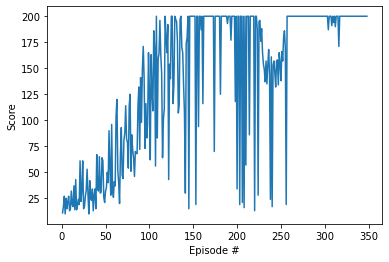

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Run the trained agent

In [6]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(5000):
    action, _ = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()